WRC+ Predections

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

import predections

In [2]:
nn_02_preds = pd.read_csv('./models/wrc_models/2025_Predections/nn_02_23_preds.csv')
nn_15_preds = pd.read_csv('./models/wrc_models/2025_Predections/nn_15_23_preds.csv')
nn_23_preds = pd.read_csv('./models/wrc_models/2025_Predections/nn_23_preds.csv')
reg_02_preds = pd.read_csv('./models/wrc_models/2025_Predections/reg_02_23_preds.csv')
reg_15_preds = pd.read_csv('./models/wrc_models/2025_Predections/reg_15_23_preds.csv')
reg_23_preds = pd.read_csv('./models/wrc_models/2025_Predections/reg_23_preds.csv')
zips_25 = pd.read_csv('./data/cleaned/zips_25.csv')

basic cleaning

In [3]:
reg_02_preds = reg_02_preds.rename(columns={'Name': 't1'})
reg_15_preds = reg_15_preds.rename(columns={'Name': 't1'})
reg_23_preds = reg_23_preds.rename(columns={'Name': 't1'})

In [4]:
reg_02_preds = reg_02_preds.rename(columns={'0': 'proj_wrc+'})
reg_15_preds = reg_15_preds.rename(columns={'0': 'proj_wrc+'})
reg_23_preds = reg_23_preds.rename(columns={'0': 'proj_wrc+'})

In [5]:
nn_02_preds = nn_02_preds.drop(columns=['Unnamed: 0'])
nn_15_preds = nn_15_preds.drop(columns=['Unnamed: 0'])
nn_23_preds = nn_23_preds.drop(columns=['Unnamed: 0'])
reg_02_preds = reg_02_preds.drop(columns=['Unnamed: 0'])
reg_15_preds = reg_15_preds.drop(columns=['Unnamed: 0'])
reg_23_preds = reg_23_preds.drop(columns=['Unnamed: 0'])

uniform names

In [6]:
def clean_names(df):
    df['t1'] = df['t1'].str.split(',').str[0]
    return df

In [7]:
# apply function
nn_02_preds = clean_names(nn_02_preds)
nn_15_preds = clean_names(nn_15_preds)
nn_23_preds = clean_names(nn_23_preds)

#### AVG of Projections

merge dfs together

In [8]:
# merge all dfs together
merged_preds = nn_02_preds.rename(columns={'proj_wrc+': 'proj_wrc+_N02'})

merged_preds = merged_preds.merge(
    nn_15_preds,
    on='t1',
    how='outer',
    suffixes=('', "_N15")
)

merged_preds = merged_preds.merge(
    nn_23_preds,
    on='t1',
    how='outer',
    suffixes=('', '_N23')
)

merged_preds = merged_preds.merge(
    reg_02_preds,
    on='t1',
    how='outer',
    suffixes=("", "_R02")
)

merged_preds = merged_preds.merge(
    reg_15_preds,
    on='t1',
    how='outer',
    suffixes=('', '_R15')
)

merged_preds = merged_preds.merge(
    reg_23_preds,
    on='t1',
    how='outer',
    suffixes=('', '_R23')
)

# rename to name col
merged_preds = merged_preds.rename(columns={'t1':'Name', 'proj_wrc+': 'proj_wrc+_N15'})


ZIPS add

In [9]:
# fix name to fit other format
zips_25['Name'] =  zips_25['Name'].str.lower()
zips_25['Name'] = zips_25['Name'].str.replace(r'[^a-z\s]', '', regex=True)
zips_wrc = zips_25[['Name', 'wRC+']]

In [10]:
merged_preds = merged_preds.merge(zips_wrc, 
                                on='Name',  
                                how='outer',
                                suffixes=('', '_zip'))

In [11]:
merged_preds = merged_preds.dropna()
merged_preds = merged_preds.rename(columns={'wRC+':'ZIPS'})

averages
<br>
<small> Adjustement Factor applied because WRC+ is centered at 100 and the models were consitently undershooting. Long term I want to use an xgboost model to predict outcomes but I currently do not have the PA model. I also think age adjustements need to be applied first. 

In [12]:
# Calculate weighted average proj_wrc+ across all models
merged_preds['avg_proj_wrc+'] = (
    merged_preds['proj_wrc+_N23'] * .25 +
    merged_preds['proj_wrc+_N15'] * 0.125 +
    merged_preds['proj_wrc+_N02'] * 0.125 +
    merged_preds['proj_wrc+_R23'] * .25 +
    merged_preds['proj_wrc+_R15'] * 0.125 +
    merged_preds['proj_wrc+_R02'] * 0.125
)

# mean 
current_mean = merged_preds['avg_proj_wrc+'].mean()

# bring back to wrc+ center
adjustment_factor = 100 / current_mean
merged_preds['avg_proj_wrc+'] = merged_preds['avg_proj_wrc+'] * adjustment_factor

analysis

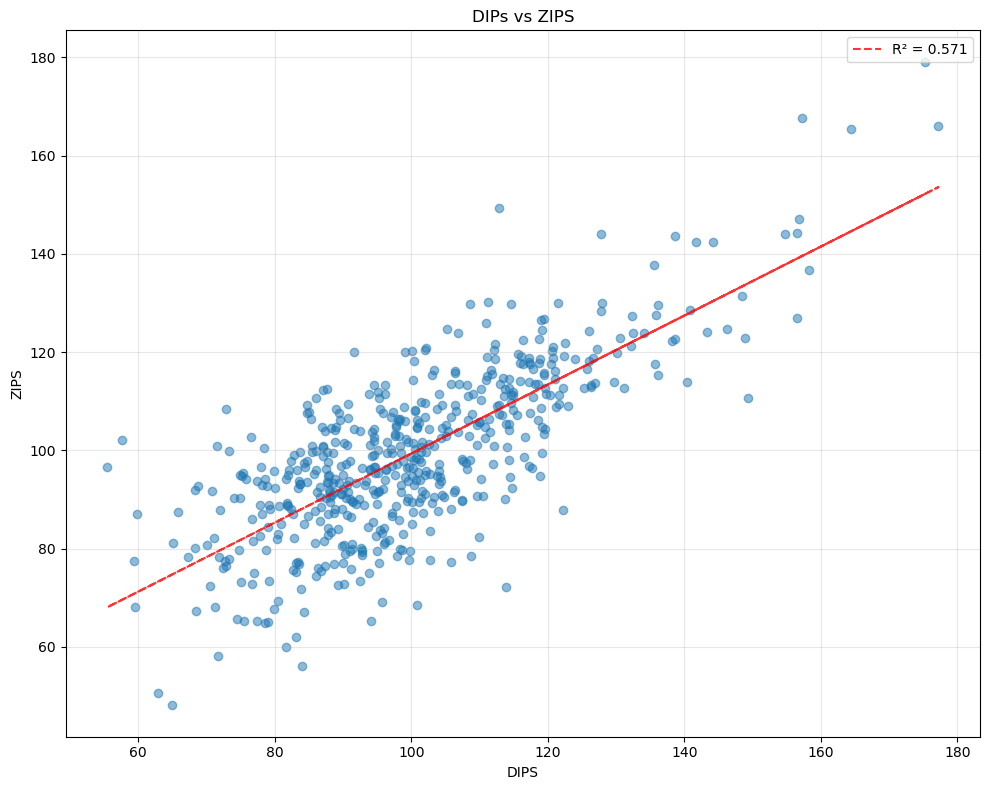

In [14]:
merged_preds['proj_diff'] = abs(merged_preds['avg_proj_wrc+'] - merged_preds['ZIPS'])
plt.figure(figsize=(10, 8))
plt.scatter(merged_preds['avg_proj_wrc+'], merged_preds['ZIPS'], alpha=0.5)

# Add line of best fit
z = np.polyfit(merged_preds['avg_proj_wrc+'], merged_preds['ZIPS'], 1)
p = np.poly1d(z)
r2 = np.corrcoef(merged_preds['avg_proj_wrc+'], merged_preds['ZIPS'])[0,1]**2

plt.plot(merged_preds['avg_proj_wrc+'], p(merged_preds['avg_proj_wrc+']), "r--", alpha=0.8, 
         label=f'R² = {r2:.3f}')

plt.xlabel('DIPS')
plt.ylabel('ZIPS')
plt.title('DIPs vs ZIPS')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()